In [1]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from sklearn.metrics import balanced_accuracy_score, accuracy_score

from deeppavlov import build_model, configs

# parser = argparse.ArgumentParser()
# parser.add_argument('--files', nargs='+', help='.csv files with model answers')
# parser.add_argument('--meta', nargs='+', help='controlled params',
#                     choices=['sent', 'da'], default=['sent', 'da'])
# parser.add_argument('--out_dir', default='./analyse',
#                     help='directory to store logs')
# args = parser.parse_args()

In [2]:
class Args:
    def __init__(self):
        self.files = ["../sentiment_da_model_mean_blend.csv"]
        self.meta = ['sent', 'da']
        self.out_dir = './analyse'
args = Args()

In [3]:
def load_dataset(filename, meta1=None, meta2=None, cut_eos=True):
    df = pd.read_csv(filename, index_col=0)
    if meta1 is not None:
        df[meta1] = df['meta'].str[2].astype(int)
    if meta2 is not None:
        df[meta2] = df['meta'].str[7].astype(int)
    df.fillna('', inplace=True)
    if cut_eos:
        df.loc[:, 'gold_answer'] = df['gold_answer'].str[
                                   :-len('<|endoftext|>')]
    return df

In [27]:
!wget https://raw.githubusercontent.com/deepmipt/DeepPavlov/feat/dialog_acts/deeppavlov/configs/classifiers/dialog_acts.json -O dialog_acts_no_hist.json

--2022-03-22 20:24:18--  https://raw.githubusercontent.com/deepmipt/DeepPavlov/feat/dialog_acts/deeppavlov/configs/classifiers/dialog_acts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3040 (3.0K) [text/plain]
Saving to: ‘dialog_acts_no_hist.json’

dialog_acts_no_hist 100%[===================>]   2.97K  --.-KB/s    in 0s      

2022-03-22 20:24:19 (50.3 MB/s) - ‘dialog_acts_no_hist.json’ saved [3040/3040]



In [28]:
da_mapping = {
    1: 'inform',
    2: 'question',
    3: 'directive',
    4: 'commissive'
}

DA_NO_HIST_CONFIG_PATH = "dialog_acts_no_hist.json"
model_no_history = build_model(DA_NO_HIST_CONFIG_PATH, download=True)

2022-03-22 20:25:04.999 INFO in 'deeppavlov.download'['download'] at line 138: Skipped http://files.deeppavlov.ai/alexaprize_data/SF/dialog_acts_classifier.tar.gz download because of matching hashes
/home/admin/miniconda3/envs/innprac37/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,
2022-03-22 20:25:09.665 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /data/home/admin/.deeppavlov/models/classifiers/dialog_acts/classes.dict]
2022-03-22 20:25:09.668 INFO in 'deeppavlov.models.torch_bert.torch_transformers_classifier'['torch_transformers_classifier'] at line 206: From pretrained bert-base-cased.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predi

In [32]:
SENTIMENT_CONFIG_PATH = "sentiment_with_hist_2.json"
sent_with_hist = build_model(SENTIMENT_CONFIG_PATH, download=True)

2022-03-22 20:27:59.588 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/alexaprize_data/SF/ScenarioSA.pickle to /data/home/admin/.deeppavlov/downloads/ScenarioSA/ScenarioSA.pickle
100%|██████████| 2.65M/2.65M [00:00<00:00, 82.7MB/s]
2022-03-22 20:27:59.647 INFO in 'deeppavlov.core.data.utils'['utils'] at line 95: Downloading from http://files.deeppavlov.ai/alexaprize_data/SF/sentiment_hist.tar.gz to /data/home/admin/.deeppavlov/models/classifiers/sentiment_hist.tar.gz
100%|██████████| 1.06G/1.06G [00:03<00:00, 300MB/s]
2022-03-22 20:28:03.202 INFO in 'deeppavlov.core.data.utils'['utils'] at line 272: Extracting /data/home/admin/.deeppavlov/models/classifiers/sentiment_hist.tar.gz archive into /data/home/admin/.deeppavlov/models/classifiers/sentiment_hist
2022-03-22 20:28:17.990 INFO in 'deeppavlov.core.data.simple_vocab'['simple_vocab'] at line 115: [loading vocabulary from /data/home/admin/.deeppavlov/models/classifiers/sentiment_h

In [33]:
def apply_da_classifier_without_hist(model, df, text_col,
                                     est_col='estimated_da',
                                     step=1000):
    for i in trange(0, len(df), step):
        index = df.iloc[i:i + step, :].index
        texts = df.loc[index, text_col]
        predictions = model(list(texts))
        df.loc[index, est_col] = predictions

    df[est_col] = df[est_col].astype(np.int32)

    return df


def apply_da_classifier_with_hist(model, df, hist_col, text_col,
                                  est_col='estimated_da',
                                  step=1000, hist_sep='<|endoftext|>',
                                  num_last=100):
    for i in trange(0, len(df), step):
        index = df.iloc[i:i + step, :].index
        texts = list(df.loc[index, text_col])
        hists = [hist.split(hist_sep)[-num_last:] for hist in
                 df.loc[index, hist_col]]
        predictions = model(hists, texts)
        df.loc[index, est_col] = predictions

    df[est_col] = df[est_col].astype(np.int32)

    return df

In [34]:
sent_mapping = {
    'NEG': 1,
    'NEU': 2,
    'POS': 3
}
sent_mapping_rev = {value: key for key, value in sent_mapping.items()}

In [35]:
def apply_sent_classifier_hist(model, df, hist_col, text_col,
                               est_col='estimated_sentiment', step=1000,
                               hist_sep='<|endoftext|>', num_last=5, max_len=100):
    for i in trange(0, len(df), step):
        index = df.iloc[i:i + step, :].index
        texts = list(df.loc[index, text_col].str[:max_len])
        hists = [hist.split(hist_sep)[-num_last:] for hist in
                 df.loc[index, hist_col]]
        predictions = model(hists, texts)
        df.loc[index, est_col] = [int(p) + 2 if p != 'here.' else 2 for p in predictions]

    df[est_col] = df[est_col].astype(np.int32)

    return df


def score(df, col1, col2, stats, prefix):
    b_acc = balanced_accuracy_score(df[col1], df[col2])
    acc = accuracy_score(df[col1], df[col2])
    print(prefix)
    print(f"Balanced accuracy: {b_acc * 100:.2f}%")
    print(f"Accuracy:          {acc * 100:.2f}%")
    stats[f'{prefix}_balanced_accuracy'] = b_acc
    stats[f'{prefix}_accuracy'] = acc


def show_missmatches(f, df, gold_meta, estimated_meta,
                     gold_answer="gold_answer",
                     model_answer=None, meta_mapping=None, seed=42,
                     num_samples=10):
    bad_df = df[df[gold_meta] != df[estimated_meta]]
    np.random.seed(seed)
    samples = np.random.choice(bad_df.index, num_samples, replace=False)

    for i in samples:
        row = bad_df.loc[i, :]
        row_gold_meta = row[gold_meta]
        row_estimated_meta = row[estimated_meta]
        if meta_mapping is not None:
            row_gold_meta = meta_mapping[row_gold_meta]
            row_estimated_meta = meta_mapping[row_estimated_meta]
        print(f'gold answer:  {row[gold_answer]}', file=f)
        if model_answer is not None:
            print(f'model answer: {row[model_answer]}', file=f)
        print(f'gold da:      {row_gold_meta}', file=f)
        print(f'estimated da: {row_estimated_meta}', file=f)
        print(file=f)
        print(file=f)


def confusion_matrix(f, df, gold_meta, estimated_meta,
                     title='Confusion matrix', xlabel='Generated',
                     ylabel='Selected branch', ticklabels=None):
    values = np.unique(df[gold_meta].to_numpy())
    pairs = np.zeros((len(values), len(values)))

    for i, g_val in enumerate(values):
        window = df[df[gold_meta] == g_val]
        for j, e_val in enumerate(values):
            pairs[i, j] = len(window[window[estimated_meta] == e_val])

    pairs /= pairs.sum(axis=1)[:, None]

    plt.figure(figsize=(12, 8))
    ax = plt.axes()
    sns.heatmap(pairs, annot=True, vmin=0., vmax=1.)
    if ticklabels is not None:
        ax.set_xticklabels(list(ticklabels))
        ax.set_yticklabels(list(ticklabels))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(f)

Analysing ../sentiment_da_model_mean_blend.csv...


  0%|          | 0/8 [00:00<?, ?it/s]/home/admin/miniconda3/envs/innprac37/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


da
Balanced accuracy: 61.58%
Accuracy:          69.67%
sent
Balanced accuracy: 70.22%
Accuracy:          70.42%


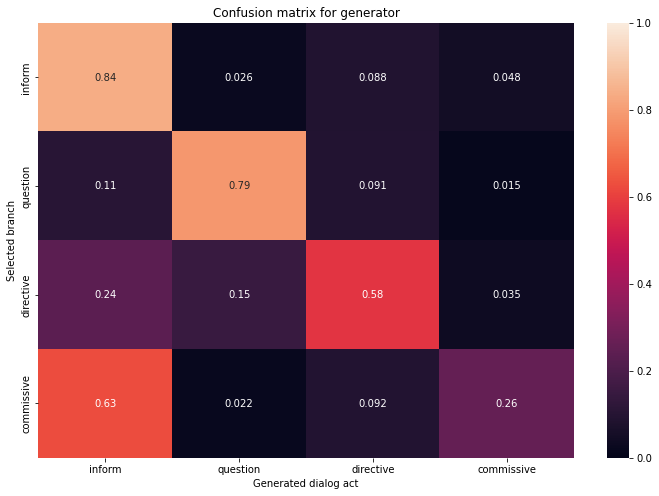

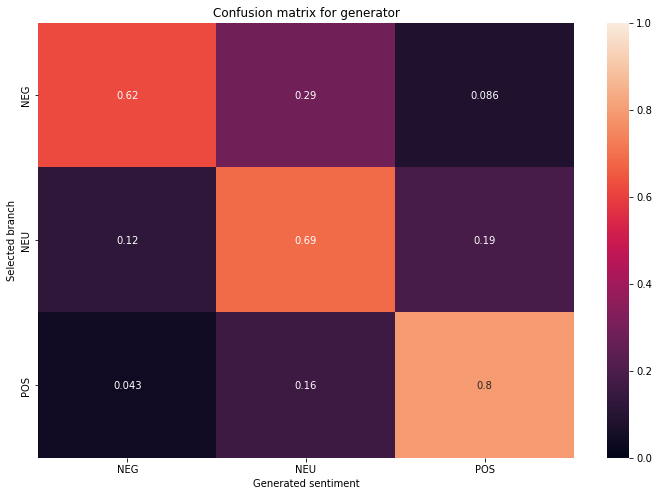

In [36]:
for filename in args.files:
    print(f'Analysing {filename}...')
    data_name = '.'.join(Path(filename).name.split('.')[:-1])
    out_dir = Path(args.out_dir) / data_name
    os.makedirs(out_dir, exist_ok=True)

    if len(args.meta) > 1:
        df = load_dataset(filename, meta1=args.meta[0], meta2=args.meta[1])
    else:
        df = load_dataset(filename, meta1=args.meta[0])
    if 'da' in args.meta:
        df = apply_da_classifier_without_hist(model_no_history, df, 'model_answer')
    if 'sent' in args.meta:
        df = apply_sent_classifier_hist(sent_with_hist, df, 'history', 'model_answer')
    df.to_csv((out_dir / 'estimated.csv').absolute())

    stats = {}
    if 'da' in args.meta:
        score(df, 'da', 'estimated_da', stats, 'da')
        with (out_dir / 'da_errors.txt').open('w') as f:
            show_missmatches(f, df, 'da', 'estimated_da', model_answer='model_answer',
                             meta_mapping=da_mapping, num_samples=50)
        confusion_matrix((out_dir / 'da_confusion.png').absolute(), df, 'da', 'estimated_da',
                         title='Confusion matrix for generator',
                         xlabel='Generated dialog act', ticklabels=da_mapping.values())

    if 'sent' in args.meta:
        score(df, 'sent', 'estimated_sentiment', stats, 'sent')
        with (out_dir / 'sent_errors.txt').open('w') as f:
            show_missmatches(f, df, 'sent', 'estimated_sentiment',
                             model_answer='model_answer',
                             meta_mapping=sent_mapping_rev, num_samples=50)
        confusion_matrix((out_dir / 'sent_confusion.png').absolute(), df, 'sent', 'estimated_sentiment',
                         title='Confusion matrix for generator',
                         xlabel='Generated sentiment', ticklabels=sent_mapping.keys())

    with (out_dir / 'accuracy.json').open('w') as f:
        json.dump(stats, f)